Starting Portfolio Value: 100000.00
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
no trend
没有趋势,使用布林线法则
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
no trend
没有趋势,使用布林线法则
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
no trend
没有趋势,使用布林线法则
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
increasing
有趋势,使用均线法则
BUY CREATE, 186.64
--- Position Begin
- Size: 40
- Price: 191.05
- Price orig: 0.0
- Closed: 0
- Opened: 40
- Adjbase: 191.05
--- Position End
increasing
有趋势,使用均线法则
BUY CREATE, 191.05
--- Position Begin
- Size: 80
- Price: 190.89000000000001
- Price orig: 191.05
- Closed: 0
- Opened: 40
- Adjbase: 190.73
--- Position End
increasing
有趋势,使用均线法则
BUY CREATE, 190.73
--- Position Begin
- Size: 120
- Price: 189.

<IPython.core.display.Javascript object>


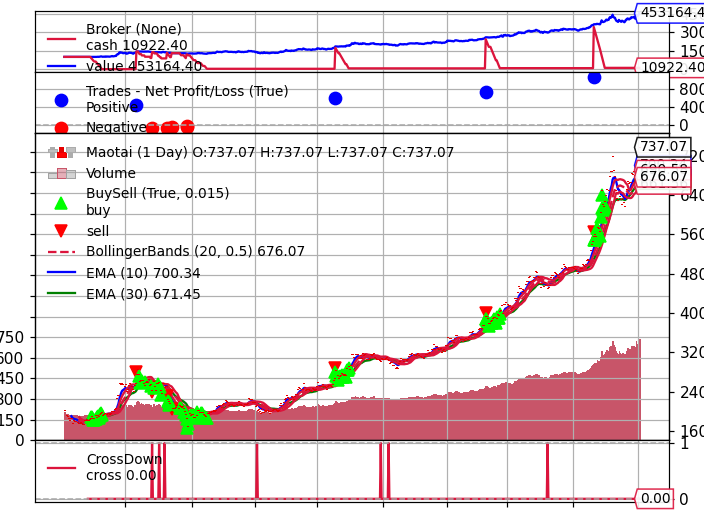

In [44]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  
import os.path  
import sys  

# 导入backtrader
import backtrader as bt
import numpy as np
import pymannkendall as mk

# 创建策略
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15), ('trend_test_period', 20), ("period", 20), ("devfactor", 0.5), ("debug", False), ("size", 1),
        ("trail", False), ("stop_loss", 0.02), # price is 2% less than the entry point
        ("fast_ma", 10), ("slow_ma", 30), ('sl', 8.0)#止损率为sl%, ('rr_ratio', 5)#止盈率是止损率的rr_ratio倍, ('n', 5),
        ("flag", True), # flag == True多头,否则空头
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        #if self.params.printlog or doprint:
         #    dt = dt or self.datas[0].datetime.date(0)
          #   print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # 创建line对象，跟踪收盘价
        self.dataclose = self.datas[0].close
        #设置变点检验的区间
        self.data_trend_test = self.datas[0].get(size=self.p.trend_test_period)  # ago defaults to 0
        #初始化order变量
        self.order, self.sl_order, self.tp_order = None, None, None
        self.buyprice = None
        self.buycomm = None
        #
        #初始化布林线
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)
        # omitting a data implies self.datas[0] (aka self.data and self.data0)
        self.fast_ma = bt.ind.EMA(period=self.p.fast_ma)
        self.slow_ma = bt.ind.EMA(period=self.p.slow_ma)
        # our entry point
        self.crossup = bt.ind.CrossDown(self.fast_ma, self.slow_ma)
       
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order已经创建执行
            return

        # 钱不够的情况下Broker可以阻止order的创建
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f, Size %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm,
                          order.executed.size))
            

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        else:
            #交易关闭后取消sl_order和tp_order变量
            if self.sl_order:
                self.broker.cancel(self.sl_order)
                self.sl_order = None
                self.sl_price = 0.0

            if self.tp_order:
                self.broker.cancel(self.tp_order)
                self.tp_order = None
                self.tp_price = 0.0
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # 打印持仓信息
        print(self.position)
        #止损和利润确认
        if self.position:
            price_sl_long = self.position.price * (1 - self.p.sl / 100)
            price_sl_short = self.position.price * (1 + self.p.sl / 100)

            price_tp_long = self.position.price * (1 + self.p.sl / 100 * self.p.rr_ratio)
            price_tp_short = self.position.price * (1 - self.p.sl / 100 * self.p.rr_ratio)
            
            # cancel existing stop loss and take profit orders
            if self.sl_order:
                self.broker.cancel(self.sl_order)

            if self.tp_order:
                self.broker.cancel(self.tp_order)

            # check & update stop loss order
            self.sl_price = 0.0
            if self.position.size > 0 and price_sl_long !=0: self.sl_price = price_sl_long
            if self.position.size < 0 and price_sl_short !=0: self.sl_price = price_sl_short

            if self.sl_price != 0.0:
                self.sl_order = self.order_target_value(target=0.0, exectype=bt.Order.Stop,
                                                        price=self.sl_price)
            # check & update take profit order
            self.tp_price = 0.0
            if self.position.size > 0 and price_tp_long !=0: self.tp_price = price_tp_long
            if self.position.size < 0 and price_tp_short !=0: self.tp_price = price_tp_short

            if self.tp_price != 0.0:
                self.tp_order = self.order_target_value(target=0.0, exectype=bt.Order.Limit,
                                                        price=self.tp_price)
        #进行趋势检验
        self.trend_test_data = self.data.get(size=self.params.trend_test_period)
        trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(self.trend_test_data)
        print(trend)
        #没有趋势时，用布林线法则
        if trend == 'no trend':
            print('没有趋势,使用布林线法则')
            # 多头
            if self.p.flag:
                # 已开仓
                if self.position.size > 0: 
                    if self.dataclose[0] < self.boll.lines.bot:
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])
                        self.order = self.buy()
                #还没有持仓的情形
                elif self.position.size == 0:
                    if self.dataclose[0] < self.boll.lines.bot:
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])
                        self.order = self.buy()
                else:
                    print("已取消空头机制")
            # # 空头
            # else:
            #     # 已开仓
            #     if self.position.size < 0:
            #         if self.dataclose[0] > self.boll.lines.top:
            #             self.log('SELL CREATE, %.2f' % self.dataclose[0])
            #             self.order = self.sell() 
            #         elif self.dataclose[0] < self.boll.lines.bot:
            #             self.log('BUY CREATE, %.2f' % self.dataclose[0])
            #             self.order = self.buy()
            #         else:
            #             self.log('close short, %.2f' % self.dataclose[0])
            #             self.order = self.close()
            #     #还没有持仓的情形
            #     elif self.position.size == 0:
            #         if self.dataclose[0] > self.boll.lines.top:
            #             self.log('SELL CREATE, %.2f' % self.dataclose[0])
            #             self.order = self.sell() 
            #         else:
            #             self.log('close short, %.2f' % self.dataclose[0])
            #             self.order = self.close()
            #     else:
            #         print("wtf!!!")

        # 有趋势时，采用格兰维尔法则，实现买点1和卖点5
        else:  
            print('有趋势,使用均线法则')
            if self.order:
                return

            # 多头
            if self.p.flag: 
                # 已开仓
                if self.position.size > 0:
                    if self.dataclose[0] > self.fast_ma : # 金叉
                        print('BUY CREATE, %.2f' % self.dataclose[0])
                        self.order = self.buy()
                #还没有持仓的情形
                elif self.position.size == 0:
                    if self.dataclose[0] > self.fast_ma: # 金叉
                        print('BUY CREATE, %.2f' % self.dataclose[0])
                        self.order = self.buy()            
                else:
                    print("已取消空头机制")
                
            # 空头
            # else:
                # 已开仓
                # if self.position.size < 0:
                #     if self.dataclose[0] > self.fast_ma[0] and self.crossup > 0: # 金叉
                #         self.log('BUY CREATE, %.2f' % self.dataclose[0])
                #         self.order = self.buy(size=self.position.size)
                #     elif self.dataclose[0] < self.fast_ma[0] and self.crossup < 0: # 死叉
                #         self.log('SELL CREATE, %.2f' % self.dataclose[0])
                #         self.order = self.sell()
                #     else:
                #         self.log('close long, %.2f' % self.dataclose[0])
                #         self.order = self.close()
                # #还没有持仓的情形
                # elif self.position.size == 0:
                #     if self.dataclose[0] < self.fast_ma[0] and self.crossup < 0: # 死叉
                #         self.log('SELL CREATE, %.2f' % self.dataclose[0])
                #         self.order = self.sell()
                #     else:
                #         self.log('close long, %.2f' % self.dataclose[0])
                #         self.order = self.close()
                # else:
                #     print("wtf!!!")


if __name__ == '__main__':
    # 创建一个cerebro实体
    cerebro1 = bt.Cerebro() # 多头

    # 向实体中添加策略
    cerebro1.addstrategy(TestStrategy, flag=True) # 多头

    # 创建 Data Feed
    data = bt.feeds.GenericCSVData(
        dataname='D:\desktop\Maotai.csv',
        fromdate=datetime.datetime(2015, 1, 5),
        todate=datetime.datetime(2018, 1, 5),
        nullvalue=0.0,
        dtformat=('%Y-%m-%d'),
        datetime=0,
        open = 1,
        high = 2,
        low = 3,
        close = 4,
        volume =5, 
        openinterest=-1,
        reverse=False)

    # 在cerebro中添加数据
    cerebro1.adddata(data)

    # 设置初始现金值
    cerebro1.broker.setcash(100000.0)

    # 固定交易的手数
    cerebro1.addsizer(bt.sizers.FixedSize, stake=40)

    # 设置交易手续费
    cerebro1.broker.setcommission(commission=0.0)

    # 打印开始的金额
    print('Starting Portfolio Value: %.2f' % (cerebro1.broker.getvalue()))

    # 运行
    cerebro1.run()

    # 打印最终的金额
    # print('Final Portfolio Value: %.2f' % (cerebro1.broker.getvalue() + cerebro2.broker.getvalue()))
    print('1 Portfolio Value: %.2f' % cerebro1.broker.getvalue())
    cerebro1.plot(style='candlestick')